# Random Forest with C2RCC and OSPAR Habitats 2022 dataset - Test

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import json

In [3]:
import geopandas as gpd
from shapely.geometry import Point

In [4]:
from shapely.geometry import Polygon, MultiPolygon

In [5]:
import rioxarray

In [6]:
import rasterio
from rasterio.crs import CRS

In [7]:
from rasterio.features import rasterize

In [8]:
from rasterio.transform import from_bounds, from_origin

In [9]:
from rasterio.warp import calculate_default_transform, reproject

In [10]:
from rasterio.enums import Resampling

In [11]:
from pyproj import Transformer

In [12]:
import matplotlib.pyplot as plt

In [13]:
from scipy.spatial import cKDTree

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
from scipy import stats

In [16]:
result_dir = "result-{tileId}"

In [17]:
substrate_dir = "substrate_rasters"

Specific files for this test

In [22]:
test_dir = result_dir.format(tileId='30UUA')

In [23]:
c2rcc_fp = os.path.join(test_dir, os.listdir(test_dir)[0])

In [24]:
with open('AOI_Lookup.txt', 'r') as fp:
    aoi_lookup = json.load(fp)

In [25]:
poly_id = aoi_lookup['30UUA'][os.listdir(test_dir)[0]]

In [26]:
poly_id

'20'

In [27]:
substrate_fp = os.path.join(substrate_dir, f"{poly_id}.tif")

## C2RCC

In [28]:
c2rcc_ds = xr.open_dataset(c2rcc_fp)

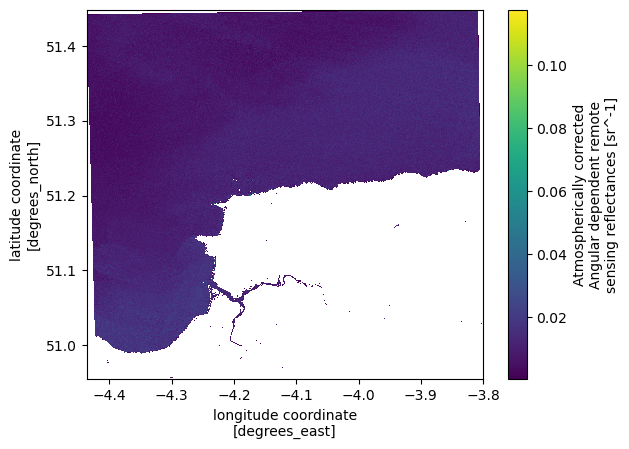

In [26]:
c2rcc_ds.rrs_B2.where(c2rcc_ds.rrs_B2 > 0).plot(x='lon', y='lat')

In [29]:
hasattr(c2rcc_ds, 'Substrate_ID')

True

Correct assigned CRS.

In [28]:
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32630', always_xy=True)

In [29]:
latitudes = c2rcc_ds['lat'].values.ravel()
longitudes = c2rcc_ds['lon'].values.ravel()

In [30]:
ny, nx = c2rcc_ds.sizes['y'], c2rcc_ds.sizes['x']

In [31]:
easting_1d, northing_1d = transformer.transform(longitudes, latitudes)

In [32]:
easting_2d = easting_1d.reshape((ny, nx)).round()
northing_2d = northing_1d.reshape((ny, nx)).round()

In [33]:
c2rcc_ds['lon'] = (['y', 'x'], easting_2d)
c2rcc_ds['lat'] = (['y', 'x'], northing_2d)
c2rcc_ds.rio.write_crs("EPSG:32630")

<xarray.Dataset> Size: 4GB
Dimensions:            (y: 5428, x: 4370, tp_y: 7, tp_x: 6)
Coordinates:
    lat                (y, x) float64 190MB 5.7e+06 5.7e+06 ... 5.646e+06
    lon                (y, x) float64 190MB 4.002e+05 4.002e+05 ... 4.438e+05
    spatial_ref        int64 8B 0
Dimensions without coordinates: y, x, tp_y, tp_x
Data variables: (12/70)
    metadata           int8 1B ...
    rrs_B1             (y, x) float32 95MB ...
    rrs_B2             (y, x) float32 95MB 0.0004668 0.0004668 ... 0.0 0.0
    rrs_B3             (y, x) float32 95MB ...
    rrs_B4             (y, x) float32 95MB ...
    rrs_B5             (y, x) float32 95MB ...
    ...                 ...
    Rhow_OOS_mask      int8 1B ...
    Kd489_OOR_mask     int8 1B ...
    Kdmin_OOR_mask     int8 1B ...
    Kd489_at_max_mask  int8 1B ...
    Kdmin_at_max_mask  int8 1B ...
    Valid_PE_mask      int8 1B ...
Attributes:
    Conventions:       CF-1.4
    TileSize:          610:610
    product_type:      C2RCC_S2-MSI
    metadata_profile:  beam
    metadata_version:  0.5
    auto_grouping:     iop:conc:rrs:rhown:kd:unc
    start_date:        23-JUN-2020 11:21:19.024000
    stop_date:         23-JUN-2020 11:21:19.024000

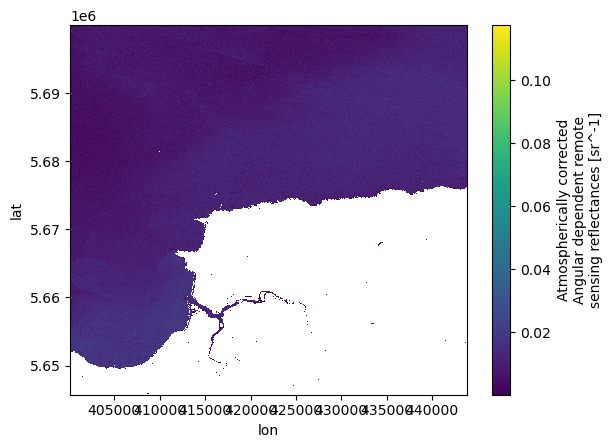

In [34]:
c2rcc_ds.rrs_B2.where(c2rcc_ds.rrs_B2 > 0).plot(x='lon', y='lat')

## Combine EUSeaMap with C2RCC

In [40]:
crs = CRS.from_epsg(4326)

In [41]:
with rasterio.open(substrate_fp) as src:
    substrate_data = src.read(1)
    transform = src.transform
    crs = src.crs

In [42]:
ny_sub, nx_sub = substrate_data.shape

In [43]:
dst_transform = from_origin(easting_2d.min(), northing_2d.max(), 10, 10)

In [44]:
with rasterio.open(substrate_fp) as src:
    src_crs = 'EPSG:4326'
    src_bounds = src.bounds
    src_width, src_height = src.width, src.height

    dst_crs = 'EPSG:32630'
    resolution = 10.0

    transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src_width, src_height, *src_bounds, resolution=resolution
    )

    reproj = np.zeros((height, width), dtype=src.dtypes[0])
    reproject(
        source=src.read(1),
        destination=reproj,
        src_transform=src.transform,
        src_crs=src_crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

In [45]:
crs = CRS.from_epsg(32630)

In [46]:
resampled = np.zeros((ny, nx), dtype=reproj.dtype)

reproject(
    source=reproj,
    destination=resampled,
    src_transform=transform,
    src_crs=crs,
    dst_transform=dst_transform,
    dst_crs=crs,
    resampling=Resampling.nearest
)

(array([[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128],
        [-128, -128, -128, ..., -128, -128, -128]], dtype=int8),
 Affine(10.0, 0.0, 370155.0,
        0.0, -10.0, 5585205.0))

Re-label missing values arbitrarily as 'Seabed'

In [47]:
resampled[resampled<0] = 17

In [48]:
substrate_band = xr.DataArray(
    resampled,
    dims=('y', 'x'),
    coords={'x': c2rcc_ds.x, 'y': c2rcc_ds.y},
    name='Substrate_ID'
)

In [49]:
c2rcc_ds['Substrate_ID'] = substrate_band

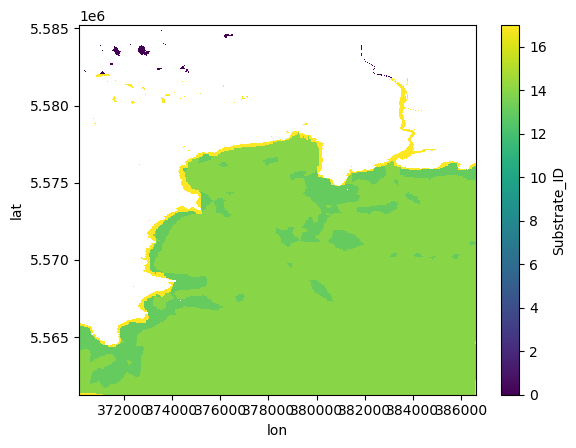

In [50]:
c2rcc_ds.Substrate_ID.where(c2rcc_ds.rrs_B2 > 0).plot(x="lon", y="lat")

## OSPAR habitat data

### Prepare dataframe

In [145]:
habitats = pd.read_csv('OSPAR2022Points.csv')

In [146]:
habitats.head()

,Join_Count,HabType,HabSubType,HabStatus,Latitude,Longitude,Energy,Biozone,Substrate,All2019DL2
0,1,Zostera beds,Unknown,Present,55.045203,-7.125105,Low energy,Infralittoral,Seabed,Infralittoral seabed
1,0,Zostera beds,Zostera noltii beds,Present,52.669012,-9.569316,NaN,NaN,NaN,NaN
2,0,Zostera beds,Zostera noltii beds,Present,52.305249,-9.854169,NaN,NaN,NaN,NaN
3,1,Zostera beds,Zostera noltii beds,Present,52.142788,-9.943158,No energy information,Infralittoral,Seabed,Infralittoral seabed
4,1,Zostera beds,Zostera marina beds,Present,52.264474,-9.825030,High energy,Infralittoral,Seabed,Infralittoral seabed


In [147]:
habitats.drop(columns=['Energy', 'Biozone', 'All2019DL2', 'Join_Count', 'HabSubType'], inplace=True)

In [148]:
habitats.head()

,HabType,HabStatus,Latitude,Longitude,Substrate
0,Zostera beds,Present,55.045203,-7.125105,Seabed
1,Zostera beds,Present,52.669012,-9.569316,NaN
2,Zostera beds,Present,52.305249,-9.854169,NaN
3,Zostera beds,Present,52.142788,-9.943158,Seabed
4,Zostera beds,Present,52.264474,-9.825030,Seabed


In [149]:
habitats['Substrate'] = habitats['Substrate'].fillna('Seabed')

In [150]:
habitats['HabType'].unique()

array(['Zostera beds', 'Intertidal mudflats', 'Maerl beds',
       'Ostrea edulis beds',
       'Sea-pen and burrowing megafauna communities',
       'Deep-sea sponge aggregations', 'Carbonate mounds',
       'Lophelia pertusa reefs', 'Coral gardens', 'Kelp forests',
       'Modiolus modiolus horse mussel beds',
       'Intertidal Mytilus edulis beds on mixed and sandy sediments',
       'Seamounts', 'Oceanic ridges with hydrothermal vents/fields',
       'Sabellaria spinulosa reefs', 'Littoral chalk communities'],
      dtype=object)

In [151]:
habtypes = ['Zostera beds', 'Kelp forests']

In [152]:
habitats['HabType'] = habitats['HabType'].apply(lambda x: x if x in habtypes else 'Other')

In [153]:
habitats['HabType'].unique()

array(['Zostera beds', 'Other', 'Kelp forests'], dtype=object)

## Extract pixel values

In [154]:
latitudes = c2rcc_ds['lat'].values.ravel()
longitudes = c2rcc_ds['lon'].values.ravel()

In [155]:
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()

In [156]:
lon_min, lat_max

(300005.0, 5573015.0)

Transform to EPSG:32630.

In [157]:
habitats['Longitude'], habitats['Latitude'] = transformer.transform(habitats['Longitude'], habitats['Latitude'])

In [158]:
habitats.head()

,HabType,HabStatus,Latitude,Longitude,Substrate
0,Zostera beds,Present,6.107602e+06,236498.048548,Seabed
1,Zostera beds,Present,5.855729e+06,56025.267222,Seabed
2,Zostera beds,Present,5.817141e+06,32947.361056,Seabed
3,Zostera beds,Present,5.799685e+06,25154.970427,Seabed
4,Zostera beds,Present,5.812426e+06,34501.919649,Seabed


In [159]:
habitats = habitats[
    (habitats['Latitude'] >= lat_min) & (habitats['Latitude'] <= lat_max) &
    (habitats['Longitude'] >= lon_min) & (habitats['Longitude'] <= lon_max)
].reset_index(drop=True)

In [160]:
coords_tree = cKDTree(np.column_stack((latitudes, longitudes)))

In [161]:
distances, nearest_indices = coords_tree.query(np.column_stack((habitats['Latitude'], habitats['Longitude'])))

In [162]:
y_indices, x_indices = np.unravel_index(nearest_indices, (ny, nx))

In [163]:
habitats['x'] = x_indices
habitats['y'] = y_indices

In [164]:
habitats.head()

,HabType,HabStatus,Latitude,Longitude,Substrate,x,y
0,Kelp forests,Present,5.544535e+06,308501.039575,Rock or other hard substrata,850,2848
1,Kelp forests,Present,5.544603e+06,308474.618446,Rock or other hard substrata,847,2841
2,Kelp forests,Present,5.546539e+06,311469.232383,Sand,1146,2648
3,Kelp forests,Present,5.546636e+06,311584.885302,Seabed,1158,2638
4,Kelp forests,Present,5.548281e+06,317119.129634,Seabed,1711,2473


In [171]:
x_arr = xr.DataArray(habitats['x'], dims=['habitat'])
y_arr = xr.DataArray(habitats['y'], dims=['habitat'])

for band in ['rrs_B2', 'rrs_B3', 'rrs_B4']:
    habitats[band] = c2rcc_ds[band].isel(x=x_arr, y=y_arr).values

In [172]:
with open('substrate_numeric.txt', 'r') as fp:
    substrate_mapping = json.load(fp)

In [173]:
habitats['Substrate_ID'] = habitats['Substrate'].map(substrate_mapping)

In [174]:
habitats.head()

,HabType,HabStatus,Latitude,Longitude,Substrate,x,y,rrs_B2,rrs_B3,rrs_B4,Substrate_ID
0,Kelp forests,Present,5.544535e+06,308501.039575,Rock or other hard substrata,850,2848,0.006851,0.006696,0.000787,13
1,Kelp forests,Present,5.544603e+06,308474.618446,Rock or other hard substrata,847,2841,0.003376,0.005052,0.001121,13
2,Kelp forests,Present,5.546539e+06,311469.232383,Sand,1146,2648,0.006595,0.002836,0.000157,14
3,Kelp forests,Present,5.546636e+06,311584.885302,Seabed,1158,2638,0.007787,0.008434,0.001136,17
4,Kelp forests,Present,5.548281e+06,317119.129634,Seabed,1711,2473,0.011341,0.009567,0.000739,17


In [212]:
len(habitats)

102

The 'Substrate' field comes from a spatial join in ArcGIS Pro, which is more accurate than the raster values in `c2rcc_ds`.

## Sample unknown points

### Convert absent points to Unknown

In [44]:
(habitats['HabStatus'] == 'Present').all()

True

In [45]:
habitats.drop(columns=['HabStatus'], inplace=True)

### Sample random unknown points

In [175]:
x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny))
all_points = np.column_stack((x_grid.ravel(), y_grid.ravel()))

In [176]:
x_arr = xr.DataArray(all_points[:,0], dims='b2')
y_arr = xr.DataArray(all_points[:,1], dims='b2')
sample_b2 = c2rcc_ds['rrs_B2'].isel(x=x_arr, y=y_arr)

In [177]:
known_xy = set(zip(habitats['x'], habitats['y']))

In [178]:
unknown_points = np.array([pt for pt in all_points[sample_b2 > 0] if tuple(pt) not in known_xy])

In [179]:
N = 100
sampled_indices = np.random.choice(len(unknown_points), N, replace=False)
sampled_points = unknown_points[sampled_indices]

In [180]:
unknown_samples = pd.DataFrame(sampled_points, columns=['x', 'y'])

In [181]:
x_arr = xr.DataArray(unknown_samples['x'], dims=['unknown'])
y_arr = xr.DataArray(unknown_samples['y'], dims=['unknown'])

for band in ['rrs_B2', 'rrs_B3', 'rrs_B4', 'Substrate_ID']:
    unknown_samples[band] = c2rcc_ds[band].isel(x=x_arr, y=y_arr).values

In [182]:
unknown_samples.head()

,x,y,rrs_B2,rrs_B3,rrs_B4,Substrate_ID
0,1676,93,0.010566,0.008994,0.001743,13
1,2438,835,0.012064,0.012142,0.001699,14
2,1991,737,0.030456,0.020928,0.000829,17
3,299,3088,0.006671,0.003135,0.000496,14
4,313,131,0.010413,0.007560,0.001248,4


In [54]:
# unknown_samples['Latitude'] = c2rcc_ds['lat'].isel(x=x_arr, y=y_arr).values
# unknown_samples['Longitude'] = c2rcc_ds['lon'].isel(x=x_arr, y=y_arr).values

In [183]:
unknown_samples['HabType'] = 'Unknown'

In [184]:
unknown_samples.head()

,x,y,rrs_B2,rrs_B3,rrs_B4,Substrate_ID,HabType
0,1676,93,0.010566,0.008994,0.001743,13,Unknown
1,2438,835,0.012064,0.012142,0.001699,14,Unknown
2,1991,737,0.030456,0.020928,0.000829,17,Unknown
3,299,3088,0.006671,0.003135,0.000496,14,Unknown
4,313,131,0.010413,0.007560,0.001248,4,Unknown


### Combine dataframes

In [185]:
habitats.drop(columns=['Latitude', 'Longitude', 'Substrate'], inplace=True)

In [189]:
ds = pd.concat([habitats, unknown_samples])

In [190]:
ds.head()

,HabType,HabStatus,x,y,rrs_B2,rrs_B3,rrs_B4,Substrate_ID
0,Kelp forests,Present,850,2848,0.006851,0.006696,0.000787,13
1,Kelp forests,Present,847,2841,0.003376,0.005052,0.001121,13
2,Kelp forests,Present,1146,2648,0.006595,0.002836,0.000157,14
3,Kelp forests,Present,1158,2638,0.007787,0.008434,0.001136,17
4,Kelp forests,Present,1711,2473,0.011341,0.009567,0.000739,17


## Train model

In [191]:
label_encoder = LabelEncoder()
ds['HabType'] = label_encoder.fit_transform(ds['HabType'])  # Store class mappings for later

In [192]:
X = ds[['Substrate_ID', 'rrs_B2', 'rrs_B3', 'rrs_B4']]
y = ds['HabType']

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [194]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

In [195]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [196]:
y_pred = clf.predict(X_test)

In [197]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

In [198]:
accuracy

0.7073170731707317

In [199]:
conf_matrix

array([[11,  0,  2,  1],
       [ 1,  0,  4,  0],
       [ 2,  0, 18,  0],
       [ 1,  1,  0,  0]])

In [200]:
label_encoder.classes_

array(['Kelp forests', 'Other', 'Unknown', 'Zostera beds'], dtype=object)

## Results

In [201]:
c2rcc_ds.sizes

Frozen({'y': 3473, 'x': 3357, 'tp_y': 5, 'tp_x': 5})

In [202]:
test = c2rcc_ds['rrs_B2'].values.ravel()

In [203]:
def xarray_pred(dataset, model, bands):
    shape = (dataset.sizes['y'], dataset.sizes['x'])
    data = {band: dataset[band].values.ravel() for band in bands}
    df = pd.DataFrame(data)
    pred = model.predict(df)
    pred_array = xr.DataArray(
        pred.reshape(shape),
        dims=('y', 'x'),
        coords={'lon': dataset.lon, 'lat': dataset.lat},
        name='pred'
    )
    return pred_array

In [204]:
pred = xarray_pred(c2rcc_ds, clf, ['Substrate_ID', 'rrs_B2', 'rrs_B3', 'rrs_B4'])

In [205]:
pred_masked = pred.where(c2rcc_ds['rrs_B2'] > 0)

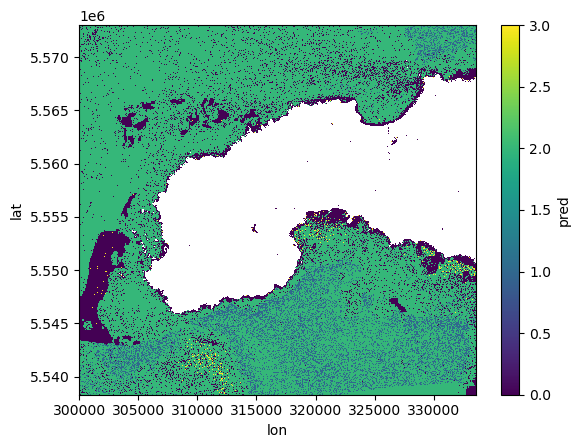

In [206]:
pred_masked.plot(x='lon', y='lat')
plt.savefig('habitat_map_test')

In [207]:
stats.mode(pred.data.flatten())

ModeResult(mode=2, count=6180664)

In [208]:
label_encoder.classes_[2]

'Unknown'

In [209]:
label_encoder.classes_[3]

'Zostera beds'

In [210]:
label_encoder.classes_

array(['Kelp forests', 'Other', 'Unknown', 'Zostera beds'], dtype=object)